In [176]:
import tensorflow as tf

def create_regression_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

### Data Collection. 
In this project, the data is collected from the Singapore Government website managed by GovTech, Singapore. This website provides various datasets relevant to different aspects of public administration, urban planning, health, transportation, and other sectors managed by the government. Using a reliable data source is crucial for building an accurate and robust machine learning model.

The dataset includes detailed information on resale transactions of HDB flats between January 1, 2017, and May 23, 2024. The dataset contains 180,154 rows and 11 columns and was downloaded on May 23, 2024. 

**Dataset URL**: [HDB Resale Prices](https://beta.data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view) 

***  In Singapore, an HDB (Housing and Development Board) estate typically refers to a large residential area that consists of multiple HDB blocks. Each HDB block is a high-rise building containing many housing units, often referred to as HDB flats or apartments. First-time buyers procure their properties directly from the Singapore government, while resale transactions involve the buying and selling of units among Singapore residents.

*** Flat types in Singapore's public housing are classified based on the number of rooms and specific designations for certain types of units, ranging from 1-room to 5-room flats, along with variations such as 2-room flexi, 3Gen, and Executive flats.

*** Flat types in Singapore's public housing are classified based on the number of rooms and specific designations for certain types of units, ranging from 1-room to 5-room flats, along with variations such as 2-room flexi, 3Gen, and Executive flats.

*** Floor ranges in Singapore's public housing are typically grouped into three-floor intervals, such as 04-06, 07-09, and so forth. 

*** Units are also classified by the generation of which the flat was made: New Generation, DBSS, Improved, and Apartment.

** Lease commencement date and remaining lease are two attributes conveying identical information. The former signifies the date when the Singapore HDB leases the property to the buyer, with all HDB properties in Singapore typically having a 99-year lease term. The remaining lease denotes the number of years remaining at the time of the transaction.

** Resale prices are indicative only as the resale prices agreed between buyers and sellers are dependent on many factors.

### Data Preprocessing. 
\subsection*{Data Preprocessing}

\subsubsection*{Categorical Data Encoding:}
\begin{enumerate}
    \item The \textit{flat type} attribute consists of 7 categories representing different sizes of flats. As this data is ordinal, it is encoded using label encoding to maintain the order of the categories based on the size of the flat.
    \item The \textit{flat model} attribute includes 21 categories, which do not have a natural order. Therefore, one-hot encoding is applied to encode this data.
    \item The \textit{town} attribute identifies the estate in which the flat is located, with 26 unique locations. As there is no inherent order or relationship among these locations, one-hot encoding is also applied to this attribute.
    \item The \textit{storey range} attribute describes the range of storeys that a flat resale falls into, such as "10 TO 12" or "01 TO 03". To simplify this categorical attribute, the range is replaced by the median value (e.g., "10 TO 12" is replaced by "11").
\end{enumerate}

\subsubsection*{Data Cleaning}
\begin{enumerate}
    \item Since the \textit{lease commencement date} and \textit{remaining lease} provide identical information, the \textit{lease commencement date} is removed from the processing to avoid redundancy.
\end{enumerate}

### Feature Engineering 
2024 Q1 == > 183.7
https://www.hdb.gov.sg/residential/selling-a-flat/overview/resale-statistics
Figure 1 illustrates a strong correlation between resale prices and transaction months. While this correlation provides valuable insights, relying solely on it for predictions may not be ideal, as it primarily reflects house price inflation.
To address the influence of inflation on resale prices, normalization techniques are employed. The HDB resale price index, which tracks overall price movements in the public residential market, is utilized for this purpose. Resale prices are adjusted using Equation (2) to account for inflation.

Figure 2 demonstrates how normalization reduces the influence of transaction dates on actual house prices. This adjustment helps to better understand the resale price of a flat by considering factors such as size, type, and location of the flat.

Inflation-Adjusted and Unadjusted Resale Price
Figure 2 shows how the adjustment reduces the effect of transaction date on the actual house prices.

As a result, the month and resale price attributes are dropped, in favour of predicting the resale price of a flat at the value of the Singaporean dollar at Q1 2024. This reframes the time series forecasting problem as a supervised learning problem, which is a more suitable approach.


In [177]:
import pandas as pd

df_raw = pd.read_csv('../data/SGHDB2017-2024.csv')
df_raw['month'] = pd.to_datetime(df_raw['month'], format='%Y-%m')
df = df_raw[df_raw['month'] < '2024-04-01']


dataset_info = pd.DataFrame(columns = ['Data Attributes', 'Column Name', 'Data Type', 'Description'])
dataset_info['Data Attributes'] = [col.capitalize().replace('_', ' ') for col in df.columns]
dataset_info['Column Name'] = df.columns
dataset_info['Data Type'] = df.dtypes.values
data_type_map = {'int64': 'Numeric', 'float64': 'Numeric',  'object': 'Text'}
dataset_info['Data Type'] = dataset_info['Data Type'].astype(str).map(data_type_map)
description = ['Month and Year of sale', 'Designated residential area', 
        'Classification of units by room size.', 
        'The Block number where the unit sold located', 
        'Stree name of the unit sold located', 
        'Estimated range of floors the unit sold was located on', 
        'Total interior space within the unit, measured in square meters', 
        'Classification of units by generation', 
        'Starting point of a lease agreement (Year)', 
        'Remaining amount of time left on the lease (Years and Months)', 
        'Resale Price of the flat sold'
    ]
dataset_info['Description'] = description
dataset_info.to_csv('../data/datasetinfo.csv')

In [178]:
df_RPI = pd.read_csv('../data/HDBRPIMonthly.csv')
df_RPI = df_RPI.iloc[:-3, :].copy()
extended_date_range = pd.date_range(start='2023-01', end='2024-03', freq='MS')
extended_formatted_dates = extended_date_range.strftime('%Y-%m').tolist()
rpi_data = [183.7, 180.4, 178.5, 176.2, 173.6][::-1] #24 t0 23 first quarter
monthly_rpi_values = [value for value in rpi_data for _ in range(3)]
df_RPI_new = pd.DataFrame({
    'month': extended_formatted_dates,
    'index': monthly_rpi_values
})
df_RPI_combined = pd.concat([df_RPI, df_RPI_new], ignore_index=True)
df_RPI_combined['month'] = pd.to_datetime(df_RPI_combined['month'], format='%Y-%m')

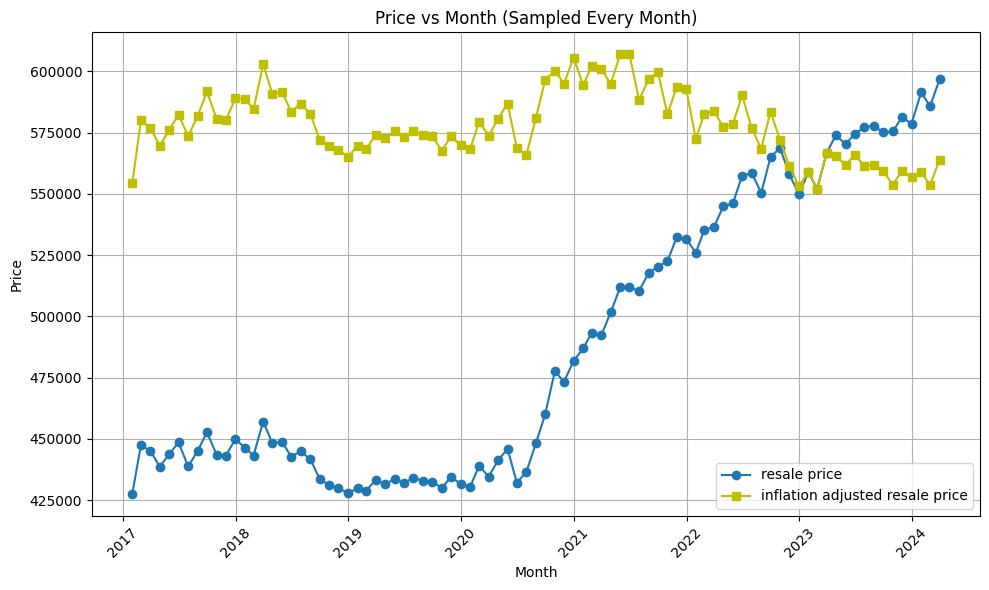

In [179]:
import pandas as pd
import matplotlib.pyplot as plt


data = df[['month', 'resale_price']].copy()
data['month'] = pd.to_datetime(data['month'], format='%Y-%m')

merged_data = pd.merge(data, df_RPI_combined, on='month', how='left')
# Sample the data points every six months
merged_data['adjusted_price'] = rpi_data[0]*merged_data['resale_price']/merged_data['index']
df_sampled = merged_data.resample('1ME', on='month').mean().reset_index()
# Plot price against month
plt.figure(figsize=(10, 6))
plt.plot(df_sampled['month'], df_sampled['resale_price'], marker='o', linestyle='-', label='resale price')
plt.plot(df_sampled['month'], df_sampled['adjusted_price'], marker='s', linestyle='-', color = 'y', label = 'inflation adjusted resale price')
plt.title('Price vs Month (Sampled Every Month)')
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('./imgs/price_inflations.png', dpi = 700)
plt.show()

In [206]:
import re
def get_meidan_from_range(flat_range):
    start, end = map(int, flat_range.strip().split(" TO "))
    return (start + end) / 2


def get_total_months(duration_str): 
    numbers = re.findall(r'\d+', duration_str)
    if(len(numbers)>1):
        return int(numbers[0])*12+int(numbers[1])
    else:
        return int(numbers[0])

In [209]:
df_clean = df[['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model', 'remaining_lease']].copy()
df_clean['adjusted_price'] = merged_data['adjusted_price']
df_clean['storey_range'] = df_clean['storey_range'].apply(get_meidan_from_range)
df_clean['remaining_lease'] = df_clean['remaining_lease'].apply(get_total_months)

In [210]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# LabelEncoder
label_encoder = LabelEncoder()
flat_type_encoded = label_encoder.fit_transform(df_clean['flat_type'])

df_encoded = df_clean.copy()
df_encoded['flat_type_encoded'] = list(flat_type_encoded)


In [212]:
# Initialize OneHotEncoder
onehot_encoder = OneHotEncoder()
town_encoded = onehot_encoder.fit_transform(df_clean[['town']])
town_encoded_df = pd.DataFrame(town_encoded.toarray(), columns=onehot_encoder.get_feature_names_out(['town']))

flat_model_encoded = onehot_encoder.fit_transform(df_clean[['flat_model']])
flat_model_encoded_df = pd.DataFrame(flat_model_encoded.toarray(), columns=onehot_encoder.get_feature_names_out(['flat_model']))

# Concatenate DataFrames
df_encoded = pd.concat([df_clean, town_encoded_df, flat_model_encoded_df], axis=1)
df_encoded.drop(columns=['town', 'flat_model', 'flat_type'], inplace=True)

(175955, 51)